Imports

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import mne
from glob import glob
from tqdm import tqdm
# from blab.itertools import true_meshgrid
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
import pingouin as pg
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Data loading

In [2]:
time = np.r_[1:9:0.004][1000:]
chlist = np.load('../data/TMS_MOTOR_CHANNELS.npy')
d1_data = np.load('../data/eeg_tfr/TMS_TIME-CH-TRIAL_DAY1_IM1-2_MOTOR-AREA_BCORR_POST.npy')
d2tms_data = np.load('../data/eeg_tfr/TMS_TIME-CH-TRIAL_DAY2_IM1-2_MOTOR-AREA_BCORR_POST.npy')
d2sham_data = np.load('../data/eeg_tfr/TMS_TIME-CH-TRIAL_DAY2_IM1-2_SHAM_MOTOR-AREA_BCORR_POST.npy')

d1_stat = np.load('../data/TMS_TIME-CH-TRIAL_DAY1_IM1-2_MOTOR-AREA_BCORR_POST_STAT-BY-SUB_NEG.npy', allow_pickle=True)
d2tms_stat = np.load('../data/TMS_TIME-CH-TRIAL_DAY2_IM1-2_MOTOR-AREA_BCORR_POST_STAT-BY-SUB_NEG.npy', allow_pickle=True)
d2sham_stat = np.load('../data/TMS_TIME-CH-TRIAL_DAY2_IM1-2_SHAM_MOTOR-AREA_BCORR_POST_STAT-BY-SUB_NEG.npy', allow_pickle=True)

res = {
    'cont': (d1_data, d1_stat),
    'TMS': (d2tms_data, d2tms_stat),
    'Sham': (d2sham_data, d2sham_stat)
}

session_names = ['Im1', 'Im2']

montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(chlist.tolist(), 1000, ch_types='eeg',)
info.set_montage(montage)

sensor_adjacency, ch_names = mne.channels.find_ch_adjacency(
    info, 'eeg')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 13


Functions

In [3]:
def plot_stat_topomap(T_obs, clus, info, axes=None, cl_ind=0):
    timefreq_mask = np.any(clus, axis=-1)
    nanmask = np.zeros(clus.shape)
    nanmask[~clus] = np.nan
    T_obs_filt = T_obs + nanmask
    topo = np.nanmean((T_obs_filt).T[:,timefreq_mask], axis=-1)
    topo[np.isnan(topo)] = 0
    return mne.viz.plot_topomap(topo, info, axes=axes, show=False, names=info.ch_names, show_names=True, extrapolate='local')

def plot_topo_n_t(time, t_obs, cluster, info, time_tr_mask=None):
    if time_tr_mask is None:
        time_tr_mask = np.ones(time.shape, dtype=bool)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(time_post[time_tr_mask], np.mean(T_obs*cluster, axis=-1)[time_tr_mask])
    ax1.set_ylabel('T value')
    ax1.set_xlabel('Time (sec)')
    ax1.grid()
    im, _ = plot_stat_topomap(t_obs[time_tr_mask], cluster[time_tr_mask], info, axes=ax2)
    plt.colorbar(im, ax=ax2)
#     ax1.set_title(f'Cluster p-value = {cluster_p_values[ind]} #{ind}')
#     fig.suptitle(f'Base vs Post: Subject {sub + 1} Day {day}; {session_name} session; {band_name} band', fontsize=20)
    fig.tight_layout()
    return fig

def local_mins(sig):
    sig_len = sig.shape[-1]
    local_min_points_mask = np.diff((np.diff(sig) < 0).astype(int)) < 0
    local_min_points_inds = np.r_[2:sig_len][local_min_points_mask]
    local_min_points_values = sig[local_min_points_inds]
    return local_min_points_inds, local_min_points_values

def plot_mins(time, sig, ax):
    tinds, vals = local_mins(sig)
    print(vals)
    mask = [True] + (np.diff(tinds) > 30).tolist()
    for tind, val in zip(tinds[mask], vals[mask]):
        timex = time[tind]
        ax.text(timex - 0.4, val, f'{timex:.3f}')
    

In [5]:
test = np.load('../data/old@TMS_TIME-CH-TRIAL_DAY1-2_IM1-2_MOTOR-AREA_BCORR_POST_STAT-BY-SUB.npy',allow_pickle=True)
df_clusters = pd.read_csv('../data/mbrt_clusters_info/mbrt_clusters.csv')

In [5]:
# [0.05/(2**0), 0.05/(2**1), 0.05/(2**2), 0.05/(2**5)]
test.shape

(2, 2, 15, 4)

MBRT calculation

In [21]:
%matplotlib inline
label = 'TMS'
data, stat = res[label]
# sub = 4
name_dict = {}
critmuls_dict = {
    0.05/(2**0): 0,
    0.05/(2**1): 1,
    0.05/(2**2): 2,
    0.05/(2**5): 3
}

def aboba(sub_real_ind, session, crit_mul_ind):
    session_name = ['Im1', 'Im2'][session]
    sub = sub_real_ind + 1
    a = data[0, session, sub_real_ind]
    a_s = np.nanstd(a, 0) # std over trials <(tr, time, ch) -> (time, ch)>
    a = np.nanmean(a, 0) # average over trials <(tr, time, ch) -> (time, ch)>
    # critmuls = [0.05/(2**0), 0.05/(2**1), 0.05/(2**2), 0.05/(2**5)]
    
    _, _, _, critmul, clus_ind, sign_channels = df_clusters.query(f'Day == "{label}" and Session == "{session_name}" and Sub == {sub}').to_numpy()[0]
    de_time = df.query(f'Day == "{label}" and Session == "{session_name}" and Subject == {sub}').to_numpy()[0, 1]

    try:
        clus_ind = int(clus_ind)
    except ValueError:
        return
    if crit_mul_ind == -1:
        crit_mul_ind = critmuls_dict[float(critmul)]

    T_obs, clusters, cluster_p_values, _ = test[1, session, sub_real_ind, crit_mul_ind]

    # inds = np.arange(len(cluster_p_values), dtype=int)[cluster_p_values < 0.3][::][:]
    inds = np.arange(len(cluster_p_values), dtype=int)[clus_ind]
    inds = [inds]
    clusters_num = len(inds)

    print(cluster_p_values)

    fig, axes = plt.subplots(clusters_num, 1, figsize=(12//2, 4*clusters_num))

    if clusters_num == 1:
        axes = [axes]

    for temp_ind, ax1 in enumerate(axes):
        ind = inds[temp_ind]
        cluster = clusters[ind]
        pval = cluster_p_values[ind]

        chmask = cluster.any(0)

        t_obs_temp = T_obs.copy() # for averaging over channels
        t_obs_temp = t_obs_temp*cluster
        t_obs_temp[~cluster] = np.nan
        t_obs_temp = np.nanmean(t_obs_temp, -1)
        t_obs_temp[np.isnan(t_obs_temp)] = 0
        f = 50
        t_obs_temp = np.convolve(t_obs_temp, np.ones(f), mode='same')/f

        a_mean = a[..., chmask].mean(-1)
        a_std = a_s[..., chmask].mean(-1)

        ax1_t = ax1.twinx()
        ax1.fill_between(time, 0, 1, where=t_obs_temp != 0,
                color='red', alpha=0.2, transform=ax1.get_xaxis_transform())
        ax1_t.plot(time, t_obs_temp)
        append = ''
        if ind == clus_ind:
#             plot_mins(time, t_obs_temp, ax1_t)
            append = 'Chosen cluster\n'
            val = t_obs_temp[np.abs(time - de_time).argmin()]
            ax1_t.text(de_time - 0.4, val, f'{de_time:.3f}')
#         except IndexError:
#             pass
        

        ax1.plot(time, a_mean, color='orange')
        ax1.fill_between(time, a_mean - a_std, a_mean + a_std, color='orange', alpha=0.1)
        ax1_t.set_ylabel('T-values')
        ax1.set_ylabel('Energy averaged over channels')
        ax1.set_xlabel('Time (sec)')
        ax1.grid()
        # im, _ = plot_stat_topomap(T_obs, cluster, info, axes=ax2)
        # plt.colorbar(im, ax=ax2)
        ax1.set_title(f'{append}cluster p-value = {pval} #{ind}')
#     fig.suptitle(f'Постстимул - престимул: Субъект {sub} День {label}; {session_name} session; High Alpha band; clusteralpha = {critmul}', fontsize=20)
    fig.tight_layout()
    plt.show();
    name_dict['dirname'] = f'../stat_by_subject_plots_may-2022-only-plot/with_fill/{label}'
    name_dict['fname'] = f'base-vs-post_day-{label}_session-{session_name}_sub-{sub}_clus_any.pdf'
    name_dict['fig'] = fig

def save_fig(description):
    fig = name_dict['fig']
    dirname = name_dict['dirname']
    fname = name_dict['fname']
    fig.savefig(f'{dirname}/{fname}')

sub_slider = widgets.IntSlider(min=0, max=14, step=1, value=0)
session_slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
crit_slider = widgets.IntSlider(min=-1, max=3, step=1, value=-1)
save_button = widgets.Button(description="Save fig")
save_button.on_click(save_fig)
display(save_button)

interact(aboba,
         sub_real_ind=sub_slider,
         session=session_slider,
         crit_mul_ind=crit_slider,
         sas_button = save_button);

Button(description='Save fig', style=ButtonStyle())

interactive(children=(IntSlider(value=0, description='sub_real_ind', max=14), IntSlider(value=0, description='…

numpy.float64

/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_29592/2605464013.py:24: RuntimeWarning: Mean of empty slice
  t_obs_temp = np.nanmean(t_obs_temp, -1)
/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_29592/1934354594.py:6: RuntimeWarning: Mean of empty slice
  topo = np.nanmean((T_obs_filt).T[:,timefreq_mask], axis=-1)


[-4.1492062  -4.17925352 -3.88725777 -4.961657   -4.93151963]


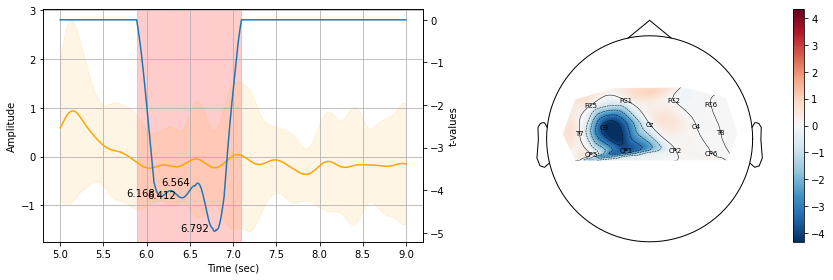

In [29]:
label = 'TMS'
data, stat = res[label]
sess = 0
day = 1
sub = 8
a = data[0, sess, sub]
a_s = np.nanstd(a, 0) # std over trials <(tr, time, ch) -> (time, ch)>
a = np.nanmean(a, 0) # average over trials <(tr, time, ch) -> (time, ch)>

critmuls = [0.05/(2**0), 0.05/(2**1), 0.05/(2**2), 0.05/(2**5)]
T_obs, clusters, cluster_p_values, _ = test[day, sess, sub, -2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ind = 1
cluster = clusters[ind]
pval = cluster_p_values[ind]

chmask = cluster.any(0)

t_obs_temp = T_obs.copy() # for averaging over channels
t_obs_temp = t_obs_temp*cluster
t_obs_temp[~cluster] = np.nan
t_obs_temp = np.nanmean(t_obs_temp, -1)
t_obs_temp[np.isnan(t_obs_temp)] = 0
f = 50
t_obs_temp = np.convolve(t_obs_temp, np.ones(f), mode='same')/f


a_mean = a[..., chmask].mean(-1)
a_std = a_s[..., chmask].mean(-1)

ax1_t = ax1.twinx()
ax1_t.plot(time, t_obs_temp, label='t-value')
try:
    plot_mins(time, t_obs_temp, ax1_t)
except IndexError:
    pass
ax1.fill_between(time, 0, 1, where=t_obs_temp != 0,
                color='red', alpha=0.2, transform=ax1.get_xaxis_transform())

ax1.plot(time, a_mean, color='orange')
ax1.fill_between(time, a_mean - a_std, a_mean + a_std, color='orange', alpha=0.1, label='Mean energy')
ax1.set_ylabel('Amplitude')

ax1_t.set_ylabel('t-values')
ax1.set_xlabel('Time (sec)')
ax1.grid()
im, _ = plot_stat_topomap(T_obs, cluster, info, axes=ax2)
plt.colorbar(im, ax=ax2)
# ax1.set_title(f'Cluster p-value = {pval} #{ind}')
# fig.suptitle(f'Base vs Post: Subject {sub_real_ind + 1} Day {label}; {["Im1", "Im2"][session]} session; High Alpha band; clusteralpha = {critmuls[crit_mul_ind]}', fontsize=20)
fig.tight_layout()
plt.show();
fig.savefig('tms_im1_sub9.pdf')

In [76]:
from itertools import product

def extract_cond(obj):
    temp = obj.split('/')[-1].split('_')
    cond = temp[1].split('-')[1]
    sess = int(temp[2][-1])
    sub = int(temp[3].split('-')[-1])
    return cond, sess, sub

def sort_func(obj):
    cond_encode = {
        'TMS': 0,
        'Sham': 1
    }
    cond, sess, sub = extract_cond(obj)
    cond_num = cond_encode[cond]
    return cond_num*(10**3) + sess*(10**2) + sub

base_path = '../stat_by_subject_plots_may-2022-only-plot/with_fill/*/*'
filenames = glob(base_path)
new_fnames = map(lambda x: '/'.join(['cluster_plots'] + x.split('/')[3:]), filenames)
new_fnames = list(new_fnames)
new_fnames = sorted(new_fnames, key=sort_func)
fnames_dict = {extract_cond(i): i for i in new_fnames}
strings = ''
cond = 'Sham'

def transform(obj):
    temp = obj.split('/')
    temp.pop(1)
    return r'\includegraphics[width=\plotscale\textwidth]{' + '/'.join(temp) + '}'

for sub in range(1, 16):
    fname1 = fnames_dict.get((cond, 1, sub), None)
    fname2 = fnames_dict.get((cond, 2, sub), None)
    fig1_string = 'No significant cluster' if fname1 is None else transform(fname1)
    fig2_string = 'No significant cluster' if fname2 is None else transform(fname2)
    result_string = f'{sub} & {fig1_string} & {fig2_string}'
    result_string = r'\hline ' + result_string + r' \\' + '\n'
    strings += result_string
print(strings)

\hline 1 & No significant cluster & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im2_sub-1_clus_any.pdf} \\
\hline 2 & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im1_sub-2_clus_any.pdf} & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im2_sub-2_clus_any.pdf} \\
\hline 3 & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im1_sub-3_clus_any.pdf} & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im2_sub-3_clus_any.pdf} \\
\hline 4 & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im1_sub-4_clus_any.pdf} & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im2_sub-4_clus_any.pdf} \\
\hline 5 & \includegraphics[width=\plotscale\textwidth]{cluster_plots/base-vs-post_day-Sham_session-Im1_sub-5_clus_any.pdf

In [74]:
fnames_dict.get(('TMS', 1, 1)).split('/')

['cluster_plots', 'tms', 'base-vs-post_day-TMS_session-Im1_sub-1_clus_any.pdf']

In [103]:
label = 'tms'
data, stat = res[label]
[0.05, 0.025, 0.0125, 0.0015625]

sub = 15
crit_mul_ind = 1
clus_ind = 1

sub_real_ind = sub - 1
session = 1
_, clusters, _, _ = test[1, session, sub_real_ind, crit_mul_ind]
[print(i, end=' ') for i in chlist[clusters[clus_ind].any(0)]];

FC5 FC1 FC2 FC6 T7 C3 Cz CP5 CP1 

MBRT aggregation

In [28]:
# low cluster alpha

d1im1_mbrt = np.r_[5.980, 5.944, 5.908, 5.728, 5.584, 6.492,  np.nan, 7.456,  5.682, np.nan, 5.576, 6.488,  6.420, 5.612, np.nan]
d1im2_mbrt = np.r_[6.120, 6.044, 6.008, 5.692, 8.088, 6.828,  np.nan, 8.264,  6.664, np.nan, 5.924, np.nan, 8.904, 5.864, 5.600 ]

d2im1_mbrt = np.r_[6.420, 5.928, 8.060, 5.952, 7.832, np.nan, np.nan, np.nan, 6.060, np.nan, 5.796, 6.016,  6.592, 5.852, 5.616, 6.560, 5.604,  6.056, 5.544, 5.832]
d2im2_mbrt = np.r_[6.096, 6.088, 8.884, 5.832, 6.408, np.nan, np.nan, np.nan, 6.464, np.nan, 5.608, 8.252,  6.144, 5.512, 5.604, np.nan, np.nan, 6.060, 5.504, 5.648]

d3im1_mbrt = np.r_[np.nan, 6.596, 5.860, 5.996, 5.872, 8.904,  7.500, 5.816, 6.464, np.nan, 6.872, 5.536, 5.492, 6.256, 6.188]
d3im2_mbrt = np.r_[5.876, 6.936, 5.780,  6.716, 7.668, np.nan, 6.196, 6.256, 6.316, 6.712, np.nan, 7.276, 6.492, 6.080, 6.096]

# any

d1im1_mbrt_any = np.r_[5.808, 5.936, 5.908, 5.888, 5.588, 6.212, np.nan, 5.984, 6.008, np.nan, 5.760, 6.540, 6.052, 5.388, 5.436]
d1im2_mbrt_any = np.r_[6.196, 5.756, 5.380, 6.036, 8.100, 5.688, 5.304,  6.056, 5.708, np.nan, 6.048, 6.584, 5.900, 5.784, 5.464]
d2im1_mbrt_any = np.r_[6.420, 6.092, 6.120, 5.924, 6.572, 6.744,  7.408, 6.728, 6.168, np.nan, 5.984, 6.764, 5.968, 5.880, 5.508, 5.512,  6.356,  6.004, 8.904, 5.888]
#                                                                 7.112
d2im2_mbrt_any = np.r_[5.544, 6.080, 6.608, 5.868, 6.400, np.nan, 6.476, 6.612, 6.488, np.nan, 6.076, 7.468, 6.344, 5.520, 5.572, np.nan, np.nan, 6.032, np.nan, 5.648]

d3im1_mbrt_any = np.r_[np.nan, 6.628, 6.692, 6.016, 8.304, 8.904,  7.492, 5.844,  6.252, 5.360, 6.872,  5.560, 5.500, 6.272, 6.164]
d3im2_mbrt_any = np.r_[5.876,  6.936, 5.764, 6.716, 8.904, np.nan, 6.148, np.nan, 6.300, 7.736, np.nan, 7.276, 6.492, 6.064, 6.112]

d1_any = d1im1_mbrt_any.tolist() + d1im2_mbrt_any.tolist()
d2_any = d2im1_mbrt_any.tolist() + d2im2_mbrt_any.tolist()
d3_any = d3im1_mbrt_any.tolist() + d3im2_mbrt_any.tolist()

d1 = d1im1_mbrt.tolist() + d1im2_mbrt.tolist()
d2 = d2im1_mbrt.tolist() + d2im2_mbrt.tolist()
d3 = d3im1_mbrt.tolist() + d3im2_mbrt.tolist()

# ind1 = pd.MultiIndex.from_product([['D1'], ['Im1', 'Im2'], list(range(1, 16))], names=['Day', 'Session', 'Subject'])
ind2 = pd.MultiIndex.from_product([['TMS'], ['Im1', 'Im2'], list(range(1, 1 + len(d2im1_mbrt_any)))], names=['Day', 'Session', 'Subject'])
ind3 = pd.MultiIndex.from_product([['Sham'], ['Im1', 'Im2'], list(range(1, 1 + 15))], names=['Day', 'Session', 'Subject'])

# df1_any = pd.DataFrame(d1_any, index=ind1, columns=['MBRT ANY'])
df2_any = pd.DataFrame(d2_any, index=ind2, columns=['MBRT ANY'])
df3_any = pd.DataFrame(d3_any, index=ind3, columns=['MBRT ANY'])
df_any = pd.concat([df2_any, df3_any])

# df1 = pd.DataFrame(d1, index=ind1, columns=['MBRT'])
df2 = pd.DataFrame(d2, index=ind2, columns=['MBRT'])
df3 = pd.DataFrame(d3, index=ind3, columns=['MBRT'])
df = pd.concat([df2, df3])
df['MBRT ANY'] = df_any['MBRT ANY']




In [56]:
desc_df = df[['MBRT ANY']].groupby(['Day', 'Session']).describe()
ste_df = df[['MBRT ANY']].groupby(['Day', 'Session']).sem()
ste_df.columns = ['sem']
new_df = desc_df.merge(ste_df, how='outer', right_index=True, left_index=True)
new_df.columns = [i[1] if isinstance(i, tuple) else i for i in new_df.columns]
new_df.index.names = ['Condition', 'Session']
new_df.to_csv('../data/mbrt/mbrt_describe.csv')

/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_7941/1612296107.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  new_df = desc_df.merge(ste_df, how='outer', right_index=True, left_index=True)


In [62]:
df_sem = df[['MBRT ANY']].groupby(['Day', 'Session']).sem()
df_mean = df[['MBRT ANY']].groupby(['Day', 'Session']).mean()
df_mean.columns = ['mean']
df_mean['sem'] = df_sem['MBRT ANY']
df_mean.to_csv('tables/mbrt_describe.csv')

In [9]:
df.to_csv('mbrt_all.csv')

In [3]:
frontal_src = pd.read_csv('../data/src_baseline_dfs/alpha_frontal.csv')
precuneus_src = pd.read_csv('../data/src_baseline_dfs/theta_precuneusr_maxt.csv')

frontal_src.set_index(['Day', 'Session', 'Subject'], inplace=True)
precuneus_src.set_index(['Day', 'Session', 'Subject'], inplace=True)
df['Precuneus_Theta'] = precuneus_src['Power']
df['Frontal_Alpha'] = frontal_src['Power']

In [4]:
df.to_csv('mbrt_mbrtany_precuneus_frontal_src.csv')

Loading and packing baseline level data

In [34]:
def base_path(day, zone, opt=''):
    assert zone in {'PrecuneusR', 'TempMidL', 'PrecuneusR_maxt'}
    dirname = '../data/baseline_level/'
    return f'{dirname}pow_avg_{day}_base1_base2_f0=6Hz_df=2Hz_eloreta_Norm_to_Im1_Bgr_{zone}.txt'

days = {'D1':range(1, 16), 'D2': range(1, 16), 'D3': range(16, 16+15)}
zones = ['PrecuneusR', 'TempMidL', 'PrecuneusR_maxt']
dfs = []
for day, drange in days.items():
    for zone in zones:
        path = base_path(day, zone)
        temp_df = pd.read_csv(path, sep='  ', header=None).iloc[:15].unstack()
        temp_df = pd.DataFrame(temp_df)
        ind = pd.MultiIndex.from_product([[f'SRC_Theta_{zone}'], [day], ['Im1', 'Im2'], list(drange)], names=['Zone', 'Day', 'Session', 'Subject'])
        # temp_df.columns = [f'SRC_Theta_{zone}']
        temp_df.index = ind
        dfs.append(temp_df)
new_df = pd.concat(dfs)
new_df = new_df.unstack(0)
new_df.columns = new_df.columns.get_level_values(1).to_list()

new_df = pd.merge(df.reset_index(), new_df.reset_index(), on=['Day', 'Session', 'Subject'])
new_df.set_index(['Day', 'Session', 'Subject'], inplace=True)
# new_df = new_df.query('Subject <= 15 or Subject >= 21')

df_delta = new_df.unstack(1).reorder_levels([1, 0], axis=1)
df_delta = df_delta['Im2'] - df_delta['Im1']
new_df.reset_index(inplace=True)
df_delta.reset_index(inplace=True)

df_delta_alpha = pd.read_csv('src_dpow_avg_D2_D3_Im2-Im1_f0=10Hz_df=2Hz_eloreta_Norm_to_Im1_Bgr_Front.txt')
df_delta = df_delta.merge(df_delta_alpha)

/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_36771/1564133322.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  temp_df = pd.read_csv(path, sep='  ', header=None).iloc[:15].unstack()
/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_36771/1564133322.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  temp_df = pd.read_csv(path, sep='  ', header=None).iloc[:15].unstack()
/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_36771/1564133322.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 cha

In [169]:
new_df.to_csv('mbrt_all_march10_stat_cluster.csv')
df_delta.to_csv('mbrt_all_march10_stat_cluster_delta.csv')

In [13]:
sas = base_path('D2', 'PrecuneusR')
pd.read_csv(sas, sep='  ', header=None).unstack()

/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_1426/1701872962.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(sas, sep='  ', header=None).unstack()


0  0    -0.307350
   1    -0.254311
   2    -0.152517
   3    -0.334555
   4    -0.192477
   5    -0.298992
   6    -0.477927
   7     0.216319
   8    -0.168316
   9     0.000000
   10    0.068581
   11   -0.222844
   12    0.077569
   13   -0.041278
   14   -0.114082
1  0    -0.041968
   1    -0.124428
   2    -0.125081
   3    -0.247127
   4     0.060173
   5    -0.184293
   6    -0.106897
   7     0.462181
   8    -0.211636
   9     0.000000
   10    0.095453
   11   -0.198904
   12    0.189958
   13    0.130386
   14    0.055025
dtype: float64

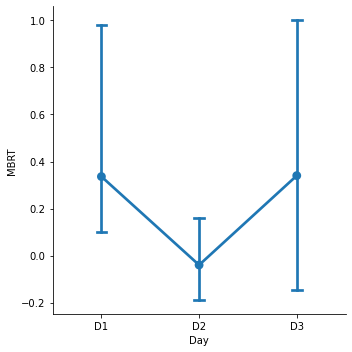

In [65]:
sns.catplot(data=df_delta, x='Day', y='MBRT', kind='point', capsize=0.1, estimator=np.nanmedian)

In [68]:
a = d1im2_mbrt - d1im1_mbrt
b = d2im2_mbrt - d2im1_mbrt
c = d3im2_mbrt - d3im1_mbrt
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
c = c[~np.isnan(c)]

stats.mannwhitneyu(b, c)

MannwhitneyuResult(statistic=58.0, pvalue=0.21291190281150452)

In [76]:
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

cohen_d(b, c)

-0.4064624310156152

In [26]:
pg.mixed_anova(df, dv='MBRT', within='Session', subject='Subject', between='Day', correction)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Day,0.136208,2,34,0.068104,0.073909,0.928905,0.004329,NaN
1,Session,2.245995,1,34,2.245995,6.072173,0.018946,0.151531,1.0
2,Interaction,1.505392,2,34,0.752696,2.034955,0.146302,0.106906,NaN


In [21]:
a = d2im2_mbrt_any - d2im1_mbrt_any
b = d3im2_mbrt_any - d3im1_mbrt_any
a = a[~np.isnan(a)]
b = b[~np.isnan(b)]
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=67.0, pvalue=0.3117289962483303)

In [15]:
index = pd.Index(list(range(1, 21)), name='Subject')
df = pd.DataFrame([d2im2_mbrt_any - d2im1_mbrt_any]).T
df.index = index
df.columns = ['Time delta']
df.reset_index(inplace=True)

theta_df = pd.read_csv('../data/TMS_BASELINE_SOURCE_THETA_DELTA.csv')

corr_df = pd.merge(df, theta_df, on='Subject')
corr_df.dropna(inplace=True)
corr_df.reset_index(inplace=True)
# corr_df = corr_df.query('Subject < 16')

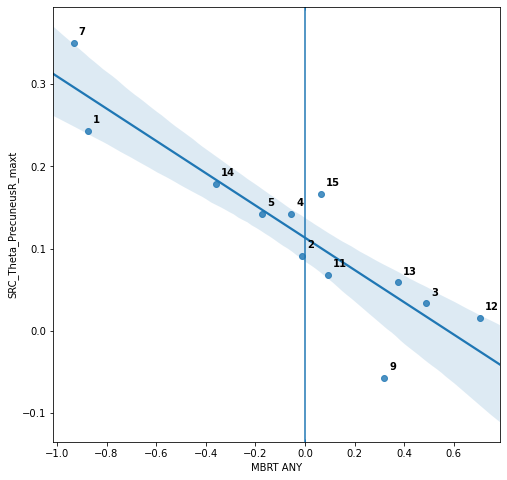

In [35]:
import seaborn as sns

fig = plt.figure(figsize=(8, 8))
d = 'D2'
x = 'MBRT ANY'
y = "SRC_Theta_PrecuneusR_maxt"
corr_df = df_delta.query(f'Day == "{d}"')[['Subject', x, y]].dropna()
g = sns.regplot(x=x, y=y, data=corr_df, truncate=False, order=1)

ax = g
# ax.figure.set_figheight(10)
# ax.set_aspect(1)


for line in range(corr_df.shape[0]):
    ax.text(corr_df[x].iloc[line] + 0.02, corr_df[y].iloc[line] + 0.01, 
    corr_df.Subject.iloc[line], horizontalalignment='left', 
    size='medium', color='black', weight='semibold')

ax.axvline(0 , marker='|')
# ax.figure.savefig(f'{d}_{x}_{y}_corr.pdf')
# ax.set_title(f'Regression {d} {y}')

In [19]:
corr_res = []
for d in df_delta.Day.unique():
    for zone in df_delta.columns[4:]:
        mbrt = 'MBRT ANY'
        base = df_delta.query(f'Day == "{d}"')[[mbrt, zone]].dropna()
        a = base[mbrt]
        b = base[zone]
        corr_res.append(stats.pearsonr(a, b))
corr_res = np.array(corr_res)
ind = pd.MultiIndex.from_product([df_delta.Day.unique(), df_delta.columns[4:]], names=['Day', 'Zone'])
corr_res = pd.DataFrame(corr_res, index=ind, columns=['Index', 'P-value'])
corr_res.query('Zone == "SRC_Theta_PrecuneusR_maxt" or Zone == "SRC_Alpha_Frontal"').to_csv('corr_data.csv')

In [163]:
stats.pearsonr(corr_df['Time delta'], corr_df['Theta delta'])

(-0.586637591506698, 0.05781746932091178)

Contains nan: True
0.0005
[ 0.4856212  -0.13216017 -0.40171841 -0.3717532  -0.29679856 -0.27460471]


C:\Users\NCT\AppData\Local\Temp/ipykernel_20712/3380981654.py:23: RuntimeWarning: Mean of empty slice
  T_obs = np.nanmean(T_obs, -1)


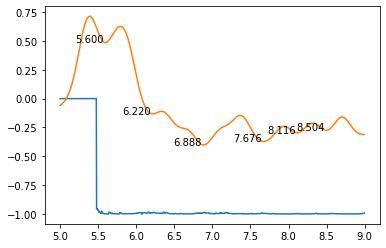

In [474]:
ax = plt.subplot(111)
day = 0
sess = 1
sub = 0
# test = stat[day, sess, sub]
T_obs, cluster_p_values = ts[day, sess, sub], ps[day, sess, sub]
print(f'Contains nan: {np.isnan(T_obs).any()}') 
# cluster_p_values = cluster_p_values.reshape(1000, 13)
# plt.hist(cluster_p_values.flatten())
print(cluster_p_values.min())
p_mask = cluster_p_values > 0.05
# cluster_p_values = cluster_p_values*np.sign(T_obs)
# T_obs = *T_obs

# f = 50
# T_obs = np.convolve(T_obs, np.ones(f), mode='same')/f

chmask = (~p_mask).any(0)

T_obs = -(1 - cluster_p_values.copy())

T_obs[p_mask] = np.nan
T_obs = np.nanmean(T_obs, -1)
T_obs[np.isnan(T_obs)] = 0

a = data[day, sess, chmask, sub].mean(0)
a = np.nanmean(a, 0)
mm = np.max(np.abs(T_obs))
plot_mins(time, a, ax)
plt.plot(time, T_obs)
plt.plot(time, a)

In [472]:
data.shape

(2, 2, 13, 15, 20, 1000)

In [91]:
# ax = plt.subplot(111)
days = [0, 1]
sessions = [0, 1]
subs = np.r_[:15]
index = pd.MultiIndex.from_product([days, sessions, subs])
conds = np.array(index.to_list())
times = []
for day, sess, sub in conds:
# day = 1
# sess = 0
# sub = 0

    # T_obs, cluster_p_values = ts[day, :, sub], ps[day, :, sub]

    # print(T_obs.shape)
    # assert False
    # chann_mask = (~np.isnan(T_obs)).any(1).all(0)
    # if not chann_mask.all():
        # print(chann_mask)
    T_obs, cluster_p_values = ts[day, sess, sub].copy(), ps[day, sess, sub].copy()
    p_mask = cluster_p_values > 0.05
    # T_obs[T_obs > 0] = np.nan
    T_obs[p_mask] = np.nan
    
    # T_obs[:50] = np.nan
    # T_obs[:] = np.nan
    # T_obs[:, ~chann_mask] = np.nan

    # chmask = (~np.isnan(T_obs)).any(0)
    # nanmask = np.isnan(T_obs)
    T_obs = np.nanmean(T_obs, -1)
    T_obs[np.isnan(T_obs)] = 0
    inds = np.argwhere(T_obs).squeeze()
    inds_diff = np.diff(inds) == 1
    groups = shift5(inds_diff, 1, False).astype(int) + (inds_diff).astype(int)
    groups[groups == 2] *= 0
    groups = np.cumsum(groups)
    

    ngroups = groups[-1] + 1

    if inds.shape != (0,):
        timepoint = time[inds[0]]
    else:
        timepoint = np.nan
    times.append(timepoint)
times = np.array(times).reshape(2, 2, 15)
print(times)
# a = data[day, sess, :, sub].mean(1)
# a = np.rollaxis(a, 1)
# print(a.shape, nanmask.shape)
# a[nanmask] = np.nan
# a = np.nanmean(a, -1)
# a[np.isnan(a)] = 0
# mm = np.max(np.abs(T_obs))
# plot_mins(time, a, ax)
# plt.plot(time, T_obs/mm)
# plt.plot(time, a)
# cluster_p_values[np.isnan]

[[[5.58  5.    5.    5.096 5.016 5.    5.    5.016 5.008 5.      nan
   5.068 5.    5.    5.   ]
  [5.    5.      nan 5.    5.    5.    5.    5.    5.    5.      nan
   5.    5.      nan 5.   ]]

 [[5.    5.    5.    5.    5.    5.    5.    5.    5.      nan   nan
   5.    5.    5.    5.   ]
  [5.032 5.424 5.    5.    5.    5.    5.016 5.496 5.092   nan 5.132
   5.    5.    5.    5.16 ]]]


/var/folders/tj/lr6p2mw95bqcmgs698v6nqx40000gn/T/ipykernel_51865/95274485.py:30: RuntimeWarning: Mean of empty slice
  T_obs = np.nanmean(T_obs, -1)


In [95]:
def shift5(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def pick_first_group(sig, thresh):
    sas = shift5(sig<=thresh, 1).astype(int) + (sig<=thresh).astype(int)
    sas[sas == 2] *= 0
    np.cumsum(sas)

inds_diff = np.diff(inds) == 1
groups = shift5(inds_diff, 1, False).astype(int) + (inds_diff).astype(int)
groups[groups == 2] *= 0
groups = np.cumsum(groups)

ngroups = groups[-1] + 1

# pick_first_group(np.diff(inds), 1)


In [450]:
x = np.r_[5.832, 6.136, 5.960, 5.972, np.nan, 6.348, np.nan, 5.836, 5.476, np.nan, 6.276, 6.524, 6.344, 5.316, np.nan]
y = np.r_[6.220, 6.016, 5.388, 6.268, 8.132,  5.688, 5.320,  5.960, 5.476, np.nan, 6.088, 7.124, 6.620, 5.520, 5.472]
a = np.r_[6.460, 5.988, 6.128, 6.140, 7.896, 6.980, np.nan, 6.772,  6.778, np.nan, 5.960, 6.740, 6.060, 5.776, 5.540]
b = np.r_[5.584, 6.124, 5.476, 5.860, 6.320, np.nan, 5.516, np.nan, 6.496, np.nan, 6.244, 7.452, 6.360, 5.360, 5.604]
ab_old = np.stack([x, y, a, b])
ab_only2 = ab_old[2:]
ab = ab_old[:, (~np.isnan(ab_old)).all(0)]
ab = ab.reshape(2, 2, -1)

Coefficient: 0.2785393484305548, p-value: 0.4679820714057366


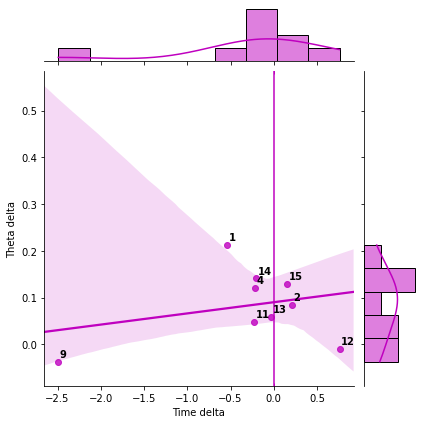

In [60]:
index = pd.Index(list(range(1, 16)), name='Subject')
df = pd.DataFrame([times[1, 1] - times[1, 0]]).T
df.index = index
df.columns = ['Time delta']
df.reset_index(inplace=True)

corr_df = pd.merge(df, theta_df, on='Subject')
corr_df.dropna(inplace=True)
corr_df.reset_index(inplace=True)

g = sns.jointplot(x='Time delta', y="Theta delta", data=corr_df,
                  kind="reg", truncate=False, order=1,
                  color="m")

ax = g.ax_joint

for line in range(0,corr_df.shape[0]):
     ax.text(corr_df['Time delta'][line] + 0.02, corr_df['Theta delta'][line] + 0.01, 
     corr_df.Subject[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

ax.axvline(0, color='m' , marker='|')
pear, pval = stats.pearsonr(corr_df['Time delta'], corr_df['Theta delta'])
print(f'Coefficient: {pear}, p-value: {pval}')

In [ ]:
from scipy.spatial.distance import squareform
Z = linkage(squareform(distancesMatrix), 'complete')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


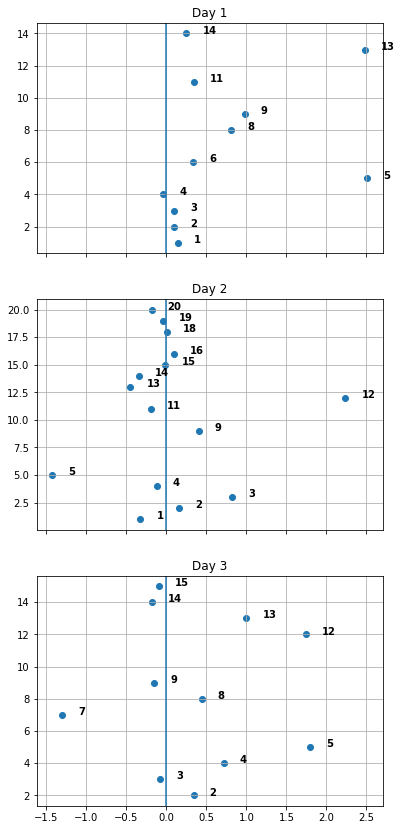

In [166]:
fig, axes = plt.subplots(3, 1, figsize=(6.2, 4.8*3), sharex=True)

d1_mbrt = d1im2_mbrt - d1im1_mbrt
d2_mbrt = d2im2_mbrt - d2im1_mbrt
d3_mbrt = d3im2_mbrt - d3im1_mbrt


mbrts = [d1_mbrt, d2_mbrt, d3_mbrt]
thresh = 20
for ind, (mbrt, ax) in enumerate(zip(mbrts, axes)):
    a = mbrt[:thresh]
    inds = np.arange(a.shape[0])+1
    ax.scatter(a,  inds)
    for subi, ti in zip(inds, a):
        ax.text(ti + 0.2, subi,
        int(subi), horizontalalignment='left', 
        size='medium', color='black', weight='semibold')
    ax.axvline()
    ax.set_title(f'Day {ind + 1}')
    ax.grid()

In [5]:
x = np.arange(0, 15, 0.2)
data_1 = np.sin(x)
data_2 = np.exp(x)

# Create Plot

fig, ax1 = plt.subplots()

ax1.set_xlabel('X-axis')
ax1.set_ylabel('Primary-axis')
ax1.plot(x, data_1, color = 'red')

# Adding Twin Axes

ax2 = ax1.twinx()
ax2.plot(x, data_2, color = 'blue')

# Add label

plt.ylabel('Secondary-axis')

# Show plot

plt.show()

[0.05, 0.025, 0.0125, 0.0015625]

150

In [ ]:
.